# Exploring sea ice heights with ICESat-2 (ATL07)

Information obtained primarily from the ATL07/10 Algorithm Theoretical Basis Document (ATBD, Kwok et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl07.   

* Notebook author: Alek Petty, relying extensively on above product manuals.    
* Description: Notebook describing the ICESat-2 ATL07 product.   
* Input requirements: Demo ATL07 data file   
* Date: June 2019
* More info: See the ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL07_ATL10_ATBD_r001.pdf    and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL0710-KnownIssues.pdf


## Notebook objectives
* General understanding of the data included in a typical ATL07 file.
* Reading in, plotting and basic analysis of ATL07 data.
* How is ATL07 data used to generate ATL10 sea ice freeboards and what to look out for when using either product.


## Notebook instructions
1. Follow along with the notebook tutorial. 
2. Play around changing options and re-running the relevant notebook cells. 

Here I use the HDF5 ATL07 file (ATL07-01_20181115003141_07240101_001_01.h5) from: https://nsidc.org/data/atl07. If using this using the ICESat-2 Pangeo instance, you can download the file from Amazon S3 using the notebook cell provided below.


## ATL07 Background

*NB: This is my laymans description of ATL07 compiled from the above resources, trying to condense this information to the key points of interest to potential sea ice users. let me know if you see any errors!*

ATL07 is arguably the most important IS2 product for sea ice users. ATL07 provides along-track surface height and type (e.g. snow-covered ice, bare ice, open water) for the ice-covered seas of the northern and southern hemispheres. The primary input is the individual photon height estimates from the Level 2A Global Geolocated Photon Data (ATL03) product. Sea surface and sea ice height are estimated for segments along each of the six beams. 

The mean sea surface (MSS) derived from ICESat/CryoSat-2, the inverted barometric (IB) correction calculated from surface pressure from ATL09 and ocean tides are subtracted from the ATL03 surface heights (relative to WGS84). 

A two-step filtering process is then used to derive heights within a given segment (along-track series) of photons. First, A coarse surface filtering method is employed to remove obviously erroneuous returns from background/subsurface/clouds etc. Second, a fine surface filtering is applied which analyzes 150 photon segments to derive the mean height. A first-photon bias estimate is included in ATL07, based on system engineering with each height estimate. Subsurface-scattering, or volume scattering, is a bias that comes from photons that experience multiple scattering within the snow or ice before returning to the satellite.  This is not included in ATL07 but is something worth considering when using the data.

Each of the 150 photon segments are then classified surface based on a decision-tree approach that determines the most likely surface type from three primary variables: the surface photon rate, the width of the photon distribution (or the fitted Gaussian) and the background rate. 

* The surface photon rate (photon returns per pulse) is a measure of the brightness, or apparent surface reflectance, of that height segment. In general, low surface rates indicate water or thin ice in open leads. 
* The width of the photon distribution provides a measure of the surface roughness and can be used to partition the height segments within four ranges that correspond to different surface types.
* The background rate provides useful additional information when the solar elevation is high and sufficient photons are present. For example, a lack of relationship between sun angle and background photon rate  can indicates shadows (cloud shadows or ridge shadows), specular returns, or possibly, atmospheric effects. 

Much of this approach was based on data collected by NASA's MABEL (Multiple Altimeter Beam Experimental Lidar) photon-counting lidar prior to the ICESat-2 launch. Calibration/validation of the ATL07 data product is underway (Operation IceBridge spring 2019 data shortly to be made available).

Below is an example of how one can read in and explore a given ATL07 file. Very open to suggestions on possible improvements!

In [1]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy.ma as ma
import h5py
import s3fs
import readers as rd
import utils as ut
import xarray as xr
from astropy.time import Time

# Use seasborn for nicer looking inline plots if available 
#import seaborn as sns
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")


#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

In [3]:
beamStr='gt1r'

In [4]:
# If file stored locally...
#file_path = '../Data/'
#ATL07_filename = 'ATL07-01_20181115003141_07240101_001_01.h5'
#localPath = file_path + ATL07_filename

In [5]:
# If running on Pangeo instance and grabbing data from Amazon S3
# Comment out the last command if you've already got the data in the Data dir
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
dataDir = 'pangeo-data-upload-oregon/icesat2/'
s3List = fs.ls(dataDir)
print(s3List)
ATL07file='ATL07-01_20181115003141_07240101_001_01.h5'
s3File='pangeo-data-upload-oregon/icesat2/'+ATL07file
localFilePath='../Data/'+ATL07file
#fs.get(s3File, localFilePath)

['pangeo-data-upload-oregon/icesat2/ATL03_20181115022655_07250104_001_01.h5', 'pangeo-data-upload-oregon/icesat2/ATL07-01_20181115003141_07240101_001_01.h5', 'pangeo-data-upload-oregon/icesat2/ATL10-01_20181115003141_07240101_001_01.h5', 'pangeo-data-upload-oregon/icesat2/NESOSIM-OSISAFsig150_ERAI_sf_SICCDR_Rhovariable_IC3_DYN1_WP1_LL1_WPF5.8e-07_WPT5_LLF2.9e-07-100kmnrt3-15082018-31012019.nc', 'pangeo-data-upload-oregon/icesat2/readme.txt', 'pangeo-data-upload-oregon/icesat2/Clouds_and_filtering_tutorial', 'pangeo-data-upload-oregon/icesat2/Floes-are-Swell', 'pangeo-data-upload-oregon/icesat2/Snowblower', 'pangeo-data-upload-oregon/icesat2/atl03', 'pangeo-data-upload-oregon/icesat2/atl06', 'pangeo-data-upload-oregon/icesat2/atl10', 'pangeo-data-upload-oregon/icesat2/atl12', 'pangeo-data-upload-oregon/icesat2/data-access-outputs', 'pangeo-data-upload-oregon/icesat2/data-access-shapefile', 'pangeo-data-upload-oregon/icesat2/data-access-subsetted-outputs', 'pangeo-data-upload-oregon/ices

In [6]:
def getATL07data(fileT, numpy=False, beam='gt1r', maxElev=1e6):
    """ Pandas/numpy ATL07 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

    I've picked out the variables from ATL07 I think are of most interest to sea ice users, but by no means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL07 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you might want
    
    Args:
        fileT (str): File path of the ATL07 dataset
        numpy (flag): Binary flag for outputting numpy arrays (True) or pandas dataframe (False)
        beam (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        maxElev (float): maximum surface elevation to remove anomalies

    returns:
        either: select numpy arrays or a pandas dataframe
        
    Updates:
        V2 (June 2018) used astropy to more simply generate a datetime instance form the gps time

    """
    
    # Open the file
    try:
        ATL07 = h5py.File(fileT, 'r')
    except:
        return 'Not a valid file'
    
    lons=ATL07[beam+'/sea_ice_segments/longitude'][:]
    lats=ATL07[beam+'/sea_ice_segments/latitude'][:]
    
    # Along track distance 
    # I removed the first point so it's distance relative to the start of the beam
    along_track_distance=ATL07[beam+'/sea_ice_segments/seg_dist_x'][:] - ATL07[beam+'/sea_ice_segments/seg_dist_x'][0]
    # Height segment ID (10 km segments)
    height_segment_id=ATL07[beam+'/sea_ice_segments/height_segment_id'][:] 
    # Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] 
    # Add this value to delta time parameters to compute full gps time
    atlas_epoch=ATL07['/ancillary_data/atlas_sdp_gps_epoch'][:] 

    leapSecondsOffset=37
    gps_seconds = atlas_epoch[0] + delta_time - leapSecondsOffset
    # Use astropy to convert from gps time to datetime
    tgps = Time(gps_seconds, format='gps')
    tiso = Time(tgps, format='datetime')
    
    # Primary variables of interest
    
    # Beam segment height
    elev=ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:]
    # Flag for potential leads, 0=sea ice, 1 = sea surface
    ssh_flag=ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] 
    
    #Quality metrics for each segment include confidence level in the surface height estimate, 
    # which is based on the number of photons, the background noise rate, and the error measure provided by the surface-finding algorithm.
    # Height quality flag, 1 for good fit, 0 for bad
    quality=ATL07[beam+'/sea_ice_segments/heights/height_segment_quality'][:] 
    
    elev_rms = ATL07[beam+'/sea_ice_segments/heights/height_segment_rms'][:] #RMS difference between modeled and observed photon height distribution
    seg_length = ATL07[beam+'/sea_ice_segments/heights/height_segment_length_seg'][:] # Along track length of segment
    height_confidence = ATL07[beam+'/sea_ice_segments/heights/height_segment_confidence'][:] # Height segment confidence flag
    reflectance = ATL07[beam+'/sea_ice_segments/heights/height_segment_asr_calc'][:] # Apparent surface reflectance
    ssh_flag = ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] # Flag for potential leads, 0=sea ice, 1 = sea surface
    seg_type = ATL07[beam+'/sea_ice_segments/heights/height_segment_type'][:] # 0 = Cloud covered
    gauss_width = ATL07[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:] # Width of Gaussian fit

    # Geophysical corrections
    # NOTE: All of these corrections except ocean tides, DAC, 
    # and geoid undulations were applied to the ATL03 photon heights.
    
    # AVISO dynamic Atmospheric Correction (DAC) including inverted barometer (IB) effect (±5cm)
    dac = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_dac'][:] 
    # Solid Earth Tides (±40 cm, max)
    earth = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_earth'][:]
    # Geoid (-105 to +90 m, max)
    geoid = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_geoid'][:] 
    # Local displacement due to Ocean Loading (-6 to 0 cm)
    loadTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_load'][:] 
    # Ocean Tides including diurnal and semi-diurnal (harmonic analysis), 
    # and longer period tides (dynamic and self-consistent equilibrium) (±5 m)
    oceanTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_ocean'][:]
    # Deformation due to centrifugal effect from small variations in polar motion 
    # (Solid Earth Pole Tide) (±1.5 cm, the ocean pole tide ±2mm amplitude is considered negligible)
    poleTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_pole'][:] 
    # Mean sea surface (±2 m)
    # Taken from ICESat and CryoSat-2, see Kwok and Morison [2015])
    mss = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:]
    
    # Photon rate of the given segment
    photon_rate = ATL07[beam+'/sea_ice_segments/stats/photon_rate'][:]
    
    # Estimated background rate from sun angle, reflectance, surface slope
    background_rate = ATL07[beam+'/sea_ice_segments/stats/backgr_calc'][:]
    
    ATL07.close()
    
    if numpy:
        # list the variables you want to output here..
        return along_track_dist, elev
    
    else:
        dF = pd.DataFrame({'elev':elev, 'lons':lons, 'lats':lats, 'ssh_flag':ssh_flag,
                          'quality_flag':quality,
                           'delta_time':delta_time,
                           'along_track_distance':along_track_distance,
                           'height_segment_id':height_segment_id, 
                           'photon_rate':photon_rate,'background_rate':background_rate,
                          'datetime':tiso, 'mss': mss, 'seg_length':seg_length})
        
         # Add the datetime string
        #dFtimepd=pd.to_datetime(dFtime)
        #dF['datetime'] = pd.Series(dFtimepd, index=dF.index)
        
        # Filter out high elevation values 
        dF = dF[(dF['elev']<maxElev)]
        # Reset row indexing
        dF=dF.reset_index(drop=True)
        return dF


#### Read in the data using the pandas reader above. Copied from the readers.py script.

Take a look at the top few rows (change the number in head to increase this..)


In [7]:
dF07=getATL07data(localFilePath, beam=beamStr)
#dF07.datetime.iloc[0].to_datetime().year

dF07.head(5)
# Or get data using xarray
#dF07X= rd.getATL07xarray(localFilePath, beamStr)
#dF07X

# ...Or data using numpy
#along_track_dist, elev=getATL07data(ATL07_file_path, numpy=1, beam=beamStr)

,elev,lons,lats,ssh_flag,quality_flag,delta_time,along_track_distance,height_segment_id,photon_rate,background_rate,datetime,mss,seg_length
0,0.443309,-164.275288,59.864463,0,1,2.747804e+07,0.000000,7,1.158333,427883.09375,2018-11-15 00:47:18.723956,11.847661,84.465149
1,0.439604,-164.275288,59.864463,0,1,2.747804e+07,0.000000,8,2.278688,427883.09375,2018-11-15 00:47:18.723956,11.847661,42.593399
2,0.469707,-164.275327,59.864671,0,1,2.747804e+07,23.241180,9,2.089552,427863.25000,2018-11-15 00:47:18.727230,11.847314,46.853153
3,0.422271,-164.275374,59.864914,0,1,2.747804e+07,50.413780,10,1.769231,427844.18750,2018-11-15 00:47:18.731058,11.846947,54.669163
4,0.392907,-164.275425,59.865173,1,1,2.747804e+07,79.494333,11,1.833333,427823.59375,2018-11-15 00:47:18.735153,11.846519,54.675667


#### Map the data for visual inspection using Cartopy 
*NB (Basemap is often used for mapping but is not being officially supported by the community anymore)*


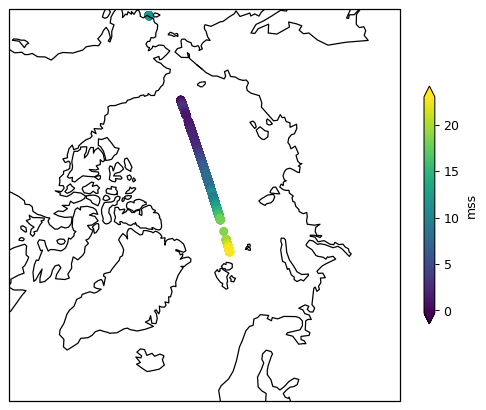

In [8]:
# Select variable of interest from the dataframe columns
var='mss'
dF07.along_track_distance
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF07['lons'], dF07['lats'],c=dF07[var], cmap='viridis', transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

In [9]:
# Get NESOSIM data which has variables including daily ice concentration from CDR dataset...

dateStr='20181115'
NESOSIMfilePath='NESOSIM-OSISAFsig150_ERAI_sf_SICCDR_Rhovariable_IC3_DYN1_WP1_LL1_WPF5.8e-07_WPT5_LLF2.9e-07-100kmnrt3-15082018-31012019.nc'
localFilePath='../Data/'
fs = s3fs.S3FileSystem()
dataDir = 'pangeo-data-upload-oregon/icesat2/'
#fs.get(dataDir+NESOSIMfilePath, localFilePath+NESOSIMfilePath)
dNday= ut.getNESOSIM(localFilePath+NESOSIMfilePath, dateStr)


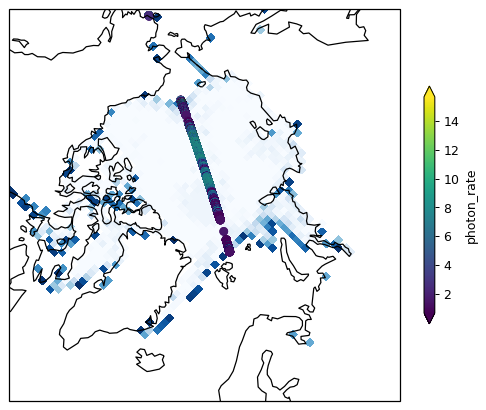

In [10]:

# Plot with ice concentration (or change to snowDepth) as a background

# Select variable of interest from the dataframe columns
var='photon_rate'
dF07.along_track_distance
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.pcolormesh(dNday['longitude'], dNday['latitude'],ma.masked_where(dNday['iceConc']<0.3, dNday['iceConc']) , cmap='Blues_r', transform=ccrs.PlateCarree())

plt.scatter(dF07['lons'], dF07['lats'],c=dF07[var], cmap='viridis', transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())




#### Plot the segment heights of this section

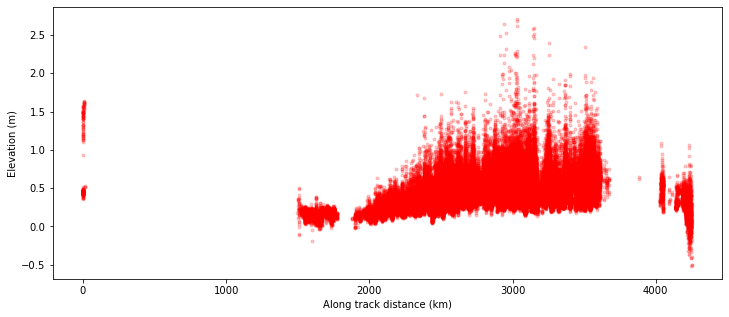

In [11]:
plt.figure(figsize=(12, 5))
plt.plot((dF07.along_track_distance)/1000., dF07.elev, color='r', marker='.', linestyle='None', alpha=0.2)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

#### Use the Pandas Groupby function to group the dataframe based on a given condition 
*surface type classification in this example..*

In [12]:
dFstype=dF07.groupby('ssh_flag')
dFstype['elev'].agg(['mean', 'std', 'median', 'mad'])
# Ice surface photons
dFstypeIce=dFstype.get_group(0)
# Lead/Sea surface photons
dFstypeLeads=dFstype.get_group(1)

# Note that in the ATL03 example I don't bother doing this 
# and just keep all the data in the table and just use a condition to display data 
# like the example commented out in the next cell..



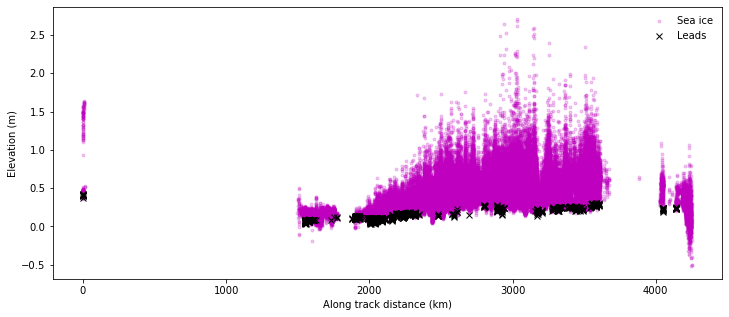

In [13]:
# Plot the grouped/classified data
plt.figure(figsize=(12, 5))
plt.plot((dFstypeIce.along_track_distance)/1000., dFstypeIce.elev, color='m', marker='.', linestyle='None', label='Sea ice', alpha=0.2)
plt.plot((dFstypeLeads.along_track_distance)/1000., dFstypeLeads.elev, color='k', marker='x', linestyle='None',label='Leads', alpha=1.)
plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

In [14]:
# An alternative (more intuitive?) approach...

#plt.figure(figsize=(12, 5))
#plt.plot((dF07[(dF07['ssh_flag']>0)]['along_track_distance']-dF07['along_track_distance'][0])/1000., dF07[(dF07['ssh_flag']>0)]['elev'], color='k', marker='x', linestyle='None',label='sea surface', alpha=1)
#plt.plot((dF07[(dF07['ssh_flag']==0)]['along_track_distance']-dF07['along_track_distance'][0])/1000., dF07[(dF07['ssh_flag']==0)]['elev'], color='b', marker='.', linestyle='None',label='ice', alpha=0.3)
#plt.legend(frameon=False)
#plt.xlabel('Along track distance (km)')
#plt.ylabel('Elevation (m)')
#plt.show()

#### Let's simplify things by just looking at a 10 km along-track section

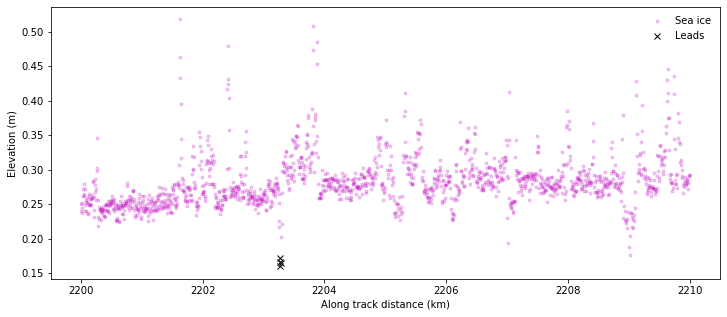

In [15]:
# Section of ATL07 data
sectionNum=220 # (NB 220 is a nice example, 200 seems to show surprisngly bad lead precisions..?)
# Section length (for plotting purposes) in meters
sectionSize=10000.

# Find data that satisfies these conditions and then group the data like before
idx=np.where((dF07['along_track_distance']>sectionNum*sectionSize)&(dF07['along_track_distance']<(sectionNum+1)*10000.))[0]
df07S=dF07.iloc[idx]
dFStype=df07S.groupby('ssh_flag')
dFStype['elev'].agg(['mean', 'std', 'median', 'mad'])
dFStypeIce=dFStype.get_group(0)
dFStypeLeads=dFStype.get_group(1)

plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev, color='m', marker='.', linestyle='None', label='Sea ice', alpha=0.2)
plt.plot((dFStypeLeads.along_track_distance)/1000., dFStypeLeads.elev, color='k', marker='x', linestyle='None',label='Leads', alpha=1.)
plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

#### Let's calculate the mean elevation of the sea surface (and sea ice) as a simple test

In [16]:
# Sea ice elevation
meanIceElev=dFstype['elev'].get_group(0).mean()
# Sea surface elevation
meanSSH=dFstype['elev'].get_group(1).mean()
print('Sea ice elevation (m):', meanIceElev)
print('SSH (m):', meanSSH)

Sea ice elevation (m): 0.3983361
SSH (m): 0.14679515


#### OK well now it's clearly pretty simple to derive some freeboard!


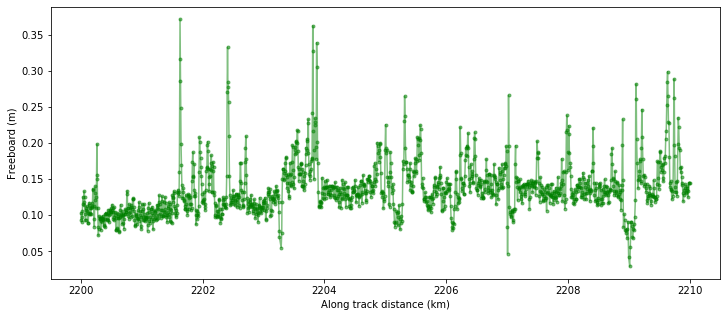

In [17]:
plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev-meanSSH, color='g', marker='.', linestyle='-', label='Freeboard', alpha=0.5)
#plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Freeboard (m)')
plt.show()

#### Explore the photon rate
*Note the higher photon rates where we have leads!*

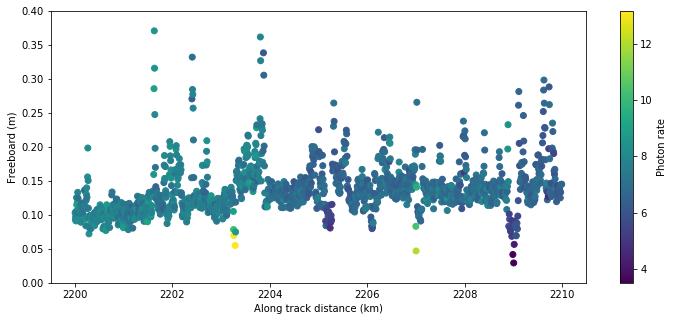

In [18]:
plt.figure(figsize=(12, 5))
plt.scatter((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev-meanSSH, c=dFStypeIce.photon_rate, label='photon_rate')
#plt.legend(frameon=False)
plt.colorbar(label='Photon rate')
plt.xlabel('Along track distance (km)')
plt.ylabel('Freeboard (m)')
plt.show()

#### Explore the background rate
*Note that this is the calculated background rate in ATL07 based on the sun angle, surface slope, unit reflectance. There is also an observed background rate at a given along-track posting (25 Hz or 200 Hz)*

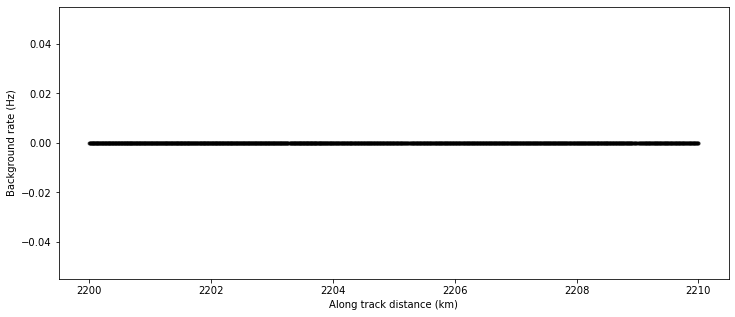

In [19]:
plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.background_rate, color='k', marker='.', linestyle='-', label='background_rate', alpha=0.5)
#plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Background rate (Hz)')
plt.show()

# Looks like it's nighttime in the Arctic!

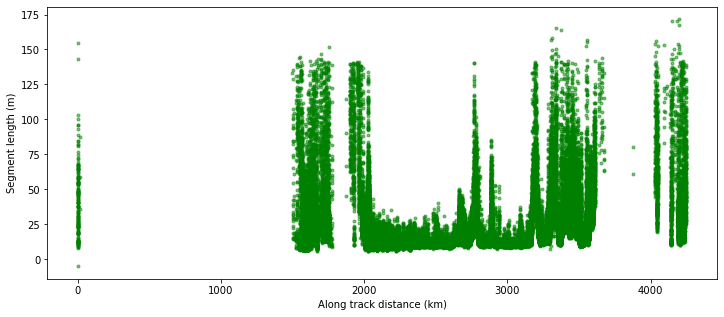

In [22]:
plt.figure(figsize=(12, 5))
plt.plot((dF07.along_track_distance)/1000., dF07.seg_length, color='g', marker='.', linestyle='', label='segment length', alpha=0.5)
#plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Segment length (m)')
plt.show()

### Extra ideas

1. Try downloading some more ATL07 data from the NSIDC (following the hackweek tutorial) and see what it looks like when using it in this processing chain. 
2. Explore the photon classification scheme.
3. Explore the photon rate and background rate. How do they variable with the open water/sea ice classification? Do some scatter plots of photon rate versus ice type. 

### Onwards to the ATL10 Notebook...!